# Timeseries Forecast with Linear Regression Model

### Import Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

### Data Loading and Overview

In [124]:
df = pd.read_csv('Month_Value_1.csv')
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Period                                    96 non-null     object 
 1   Revenue                                   64 non-null     float64
 2   Sales_quantity                            64 non-null     float64
 3   Average_cost                              64 non-null     float64
 4   The_average_annual_payroll_of_the_region  64 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


In [126]:
df.duplicated().sum()

0

There are 32 missing values on some variables. This means that we have the option to choose which variables to use for forecasting.

The Period variable is still in object datatype and need to be change to datetime datatype.



In [127]:
df.describe()

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
count,6.400000e+01,64.000000,64.000000,6.400000e+01
mean,3.236045e+07,19197.375000,1695.061159,2.869083e+07
std,1.164150e+07,6591.287257,296.844793,1.057191e+06
min,1.402148e+07,8314.000000,1110.576805,2.740647e+07
25%,2.242655e+07,15065.500000,1499.142841,2.782857e+07
50%,3.209088e+07,18368.000000,1654.399798,2.819785e+07
75%,3.992999e+07,22856.250000,1916.401096,2.987852e+07
max,5.875647e+07,38069.000000,2559.328184,3.002468e+07


Based on the statistic data we can conclude that Sales_quantitiy variable is skewed since the mean is dragged away from the median.

In [128]:
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df['Period'] = df['Period'].dt.to_period('M')

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype    
---  ------                                    --------------  -----    
 0   Period                                    96 non-null     period[M]
 1   Revenue                                   64 non-null     float64  
 2   Sales_quantity                            64 non-null     float64  
 3   Average_cost                              64 non-null     float64  
 4   The_average_annual_payroll_of_the_region  64 non-null     float64  
dtypes: float64(4), period[M](1)
memory usage: 3.9 KB


Now we have all the datatypes in correct type

### Exploratory Data

We will forecast the revenue variable, given that the data has a normal distribution.



In [130]:
tmseries = df.loc[0:63,['Period','Revenue']]
tmseries

,Period,Revenue
0,2015-01,1.601007e+07
1,2015-02,1.580759e+07
2,2015-03,2.204715e+07
3,2015-04,1.881458e+07
4,2015-05,1.402148e+07
...,...,...
59,2019-12,5.875647e+07
60,2020-01,5.628830e+07
61,2020-02,4.022524e+07
62,2020-03,5.002217e+07


In [131]:
tmseries['Month'] = tmseries['Period'].dt.month
tmseries['Year'] = tmseries['Period'].dt.year
tmseries

,Period,Revenue,Month,Year
0,2015-01,1.601007e+07,1,2015
1,2015-02,1.580759e+07,2,2015
2,2015-03,2.204715e+07,3,2015
3,2015-04,1.881458e+07,4,2015
4,2015-05,1.402148e+07,5,2015
...,...,...,...,...
59,2019-12,5.875647e+07,12,2019
60,2020-01,5.628830e+07,1,2020
61,2020-02,4.022524e+07,2,2020
62,2020-03,5.002217e+07,3,2020


In [132]:
tmseries.set_index('Period',inplace=True)
tmseries.head()

,Revenue,Month,Year
Period,,,
2015-01,1.601007e+07,1,2015
2015-02,1.580759e+07,2,2015
2015-03,2.204715e+07,3,2015
2015-04,1.881458e+07,4,2015
2015-05,1.402148e+07,5,2015


<Axes: title={'center': 'Revenue by Weekly'}, xlabel='Period'>

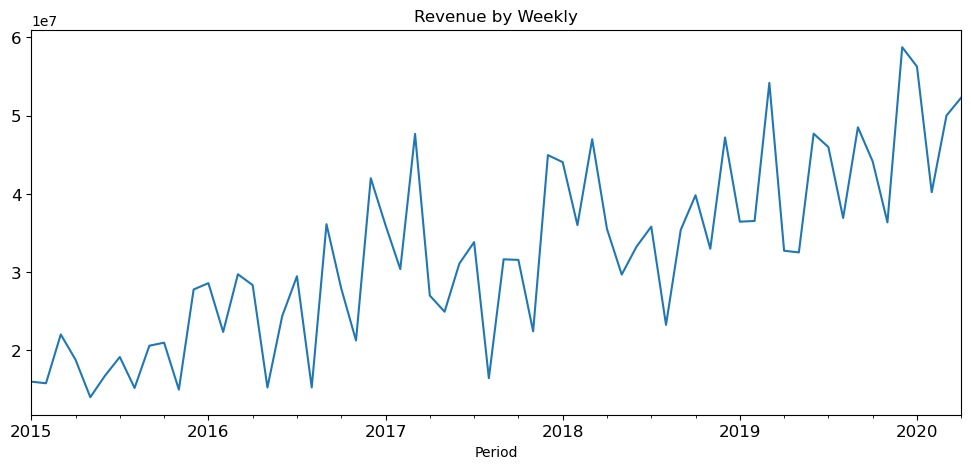

In [133]:
tmseries['Revenue'].plot(figsize=(12,5), title= 'Revenue by Weekly', fontsize=12) ## visualization

The weekly revenue visualization from 2015 to 2020 is not clear enough to see the trend. Let's check the monthly and yearly trend and distribution to get a better understanding.

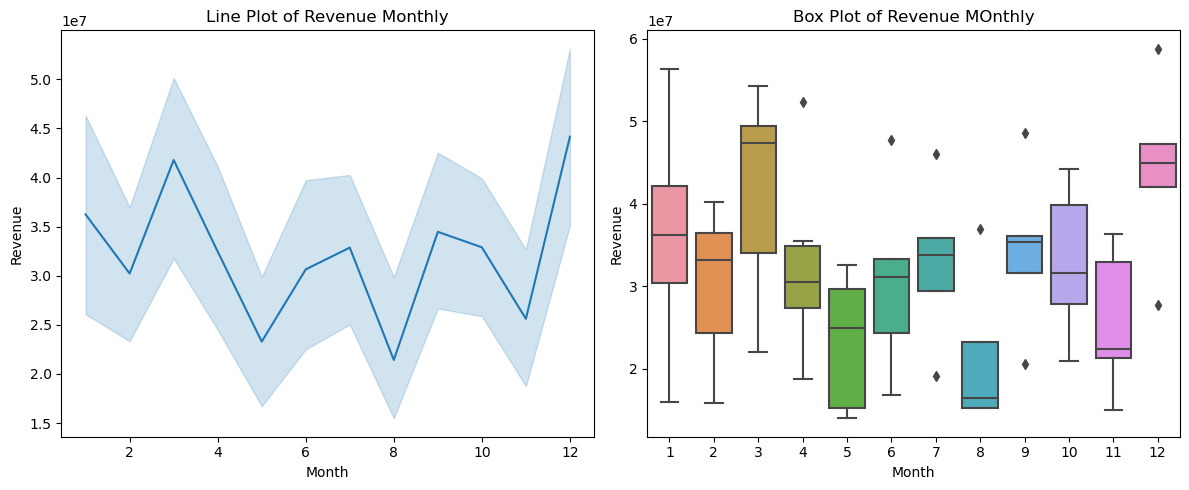

In [134]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.lineplot(x='Month', y='Revenue', data=tmseries)
plt.title('Line Plot of Revenue Monthly')

plt.subplot(122)
sns.boxplot(x='Month', y='Revenue', data=tmseries)
plt.title('Box Plot of Revenue MOnthly')

plt.tight_layout()

plt.show()


The monthly revenue trend is fluctuating, with December having the highest revenue and August having the lowest. The distribution shows some outliers, but they are not significant enough to be a concern.



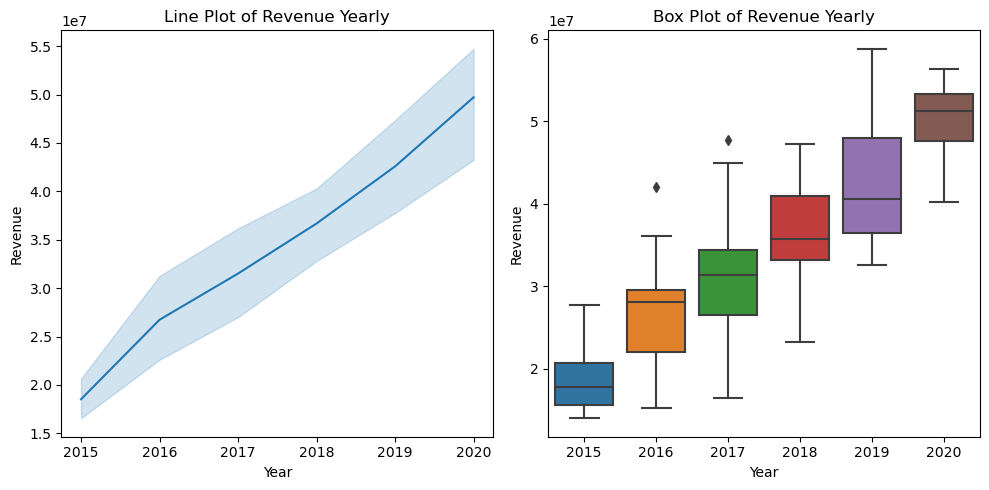

In [135]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.lineplot(x='Year', y='Revenue', data=tmseries)
plt.title('Line Plot of Revenue Yearly')

plt.subplot(122)
sns.boxplot(x='Year', y='Revenue', data=tmseries)
plt.title('Box Plot of Revenue Yearly')

plt.tight_layout()

plt.show()

By yearly we can see a clear up trend in the revenue, and the highest revenue was scored on the year 2019.

--- Seasonal Decomposition ---

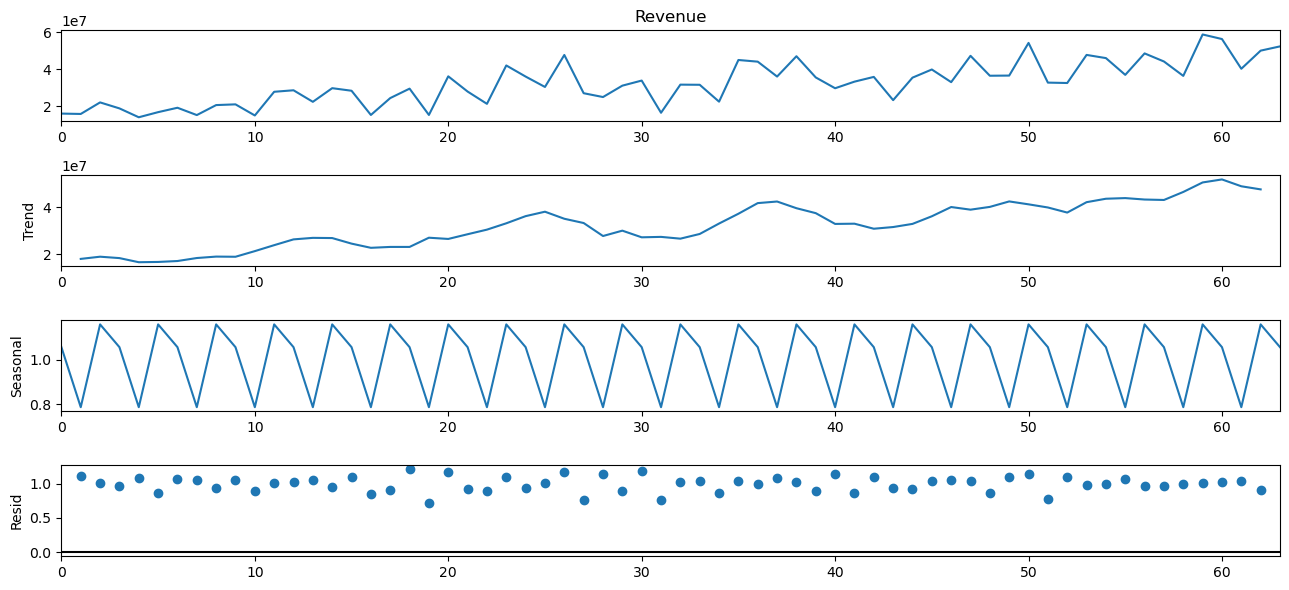

In [136]:
# Set the figure size
pylab.rcParams['figure.figsize'] = (13, 6)

# Reset index before performing seasonal decomposition
tmseries_reset_index = tmseries.reset_index()

# Perform seasonal decomposition
res = seasonal_decompose(tmseries_reset_index['Revenue'], model='multiplicative', period=3)

# Plot the decomposed components
ax = res.plot()
plt.show()

By using the seasonal decompose function, we can see that there is a clear seasonality in the data, with a period of 3 months. This means that the revenue tends to follow a similar pattern every 3 months, with higher revenue in the holiday seasons and lower revenue in the summer months. The residue is closer to 0, which indicates that the data does not contain much noise. This is good news for forecasting, as it means that we can be more confident in our predictions.

--- Stationary Test ---

In [137]:
result = adfuller(tmseries['Revenue'], autolag='AIC')
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics: -0.2691489356436311
p-value: 0.9297615379617785


As the Fuller p-value score is greater than 0.05, we cannot reject the null hypothesis that the time series is non-stationary. This means that we need to take the trend and seasonality into account when we model the data.

Linear regression can only be used for stationary time series. Since our time series is not stationary, we need to use a different approach. In this case, we will use Fourier Calendar and Deterministic Process.

### Modelling

--- Moving Average ---

<Axes: xlabel='Period'>

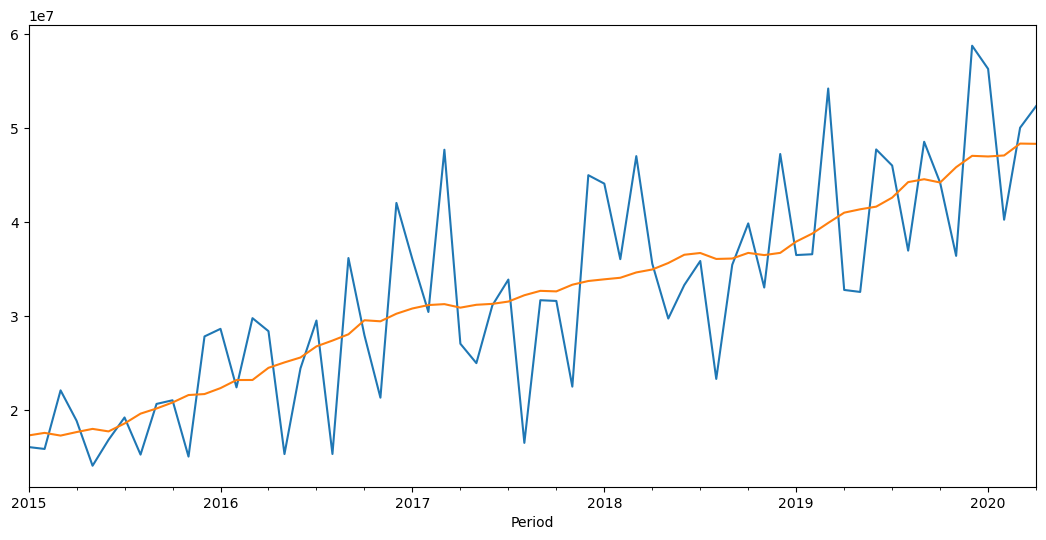

In [138]:
ma=tmseries['Revenue'].rolling(window=12,center=True,min_periods=6).mean()
ax=tmseries['Revenue'].plot()
ma.plot(ax=ax)

One of the ways to model non-stationary data is to use a moving average. However, the visualization shows that there is a lot of noise in the data, meaning that the actual revenue values are quite different from the moving average values. This suggests that moving average is not a good approach for modeling this data.

--- Fourier Transform ---

In [139]:
fourier = CalendarFourier(freq="A", order=7)

dp = DeterministicProcess(
    index=tmseries.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # quarter seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [140]:
X

,const,trend,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)",...,"cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)"
Period,,,,,,,,,,,,,,,,,,,,,
2015-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2015-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373,0.455907,-0.890028,-0.060213
2015-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056,-0.933837,0.357698,-0.188227
2015-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.021516,0.043022,-0.999074,-0.997917,-0.064508,-0.085965,0.996298,0.994218,0.107381,0.128748
2015-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.474951,-0.835925,-0.548843,-0.085965,0.996298,0.917584,-0.397543,-0.785650,-0.618671,-0.171293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860961,-0.875892,0.482508,-0.999546,-0.030120,-0.845249,-0.534373,-0.455907,-0.890028,0.060213
2020-01,1.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2020-02,1.0,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.861702,0.874481,0.485060,0.999668,-0.025748,0.848351,-0.529434,0.462383,-0.886680,-0.051479


The X above is a mathematical algorithm that uses the Fourier Transform method to decompose the time series data into its constituent frequencies. This allows us to model the trend, seasonality, and noise in the data. The important thing to remember is that X is still the training period, and it is used to train the model.

In [141]:
y = tmseries["Revenue"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=32)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

### Model Evaluation

In [142]:
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 2265643.300442837
RMSE: 3055079.3821914024
MAPE: 7.925357760312088


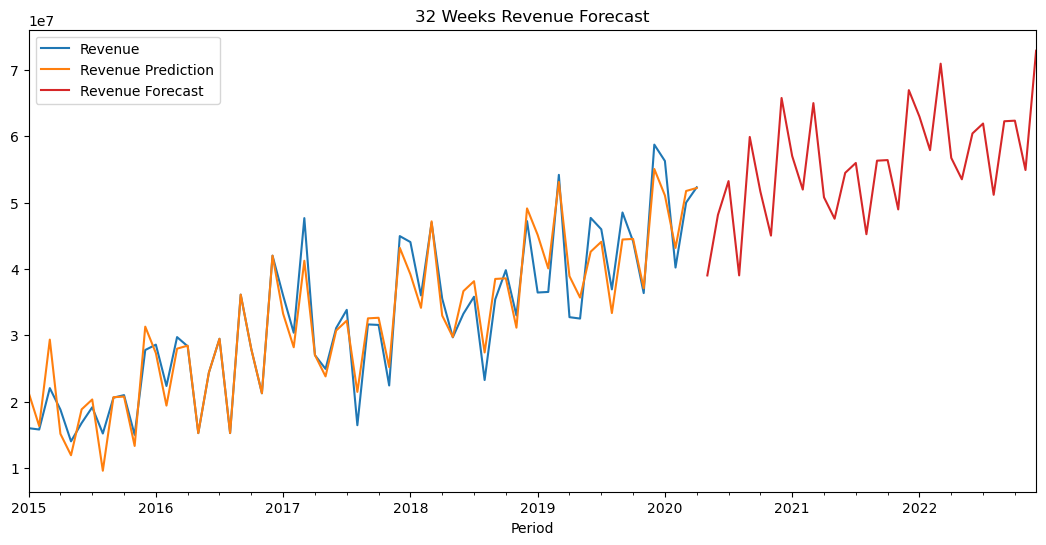

In [143]:
ax = y.plot(title="32 Weeks Revenue Forecast")
ax = y_pred.plot(ax=ax, label="Revenue Prediction")
ax = y_fore.plot(ax=ax, label="Revenue Forecast", color='C3')
plt.legend()
plt.show()

Based on the forecast, we can see that there is still an uptrend in revenue, with a decrease at the beginning of the year and a peak at the end of the year. However, the MAE and MAPE results are high, which suggests that the model is not good enough. The MAE of 2265643. means that the model's predictions are off by an average of 2,265,643 or 8% from the actual revenue. In a business setting, this kind of difference can have a significant impact on revenue and profitability.Therefore, it is important to explore other models that may be more accurate. There are a number of different time series forecasting models available, each with its own advantages and disadvantages. By comparing the MAE, RMSE, and MAPE values for different models, we can determine which model is the most accurate for our data.